# Assignment 4

Approximate time needed: 6-7 hours

Team Name: R2D2

Roll Numbers: 2019101120, 2019111030
    
## DLT and Epipolar Lines

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

The second part of this assignment will require you to construct epipolar lines on two corresponding images.

The third part of this assignment will require you to use camera intrinsics to estimate the bounding box of a car.

---
### 4.1 Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [2]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np

In [2]:
image_points = []
fig = plt.figure(figsize=(20,30))

img = mpimg.imread('q1/dlt1.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

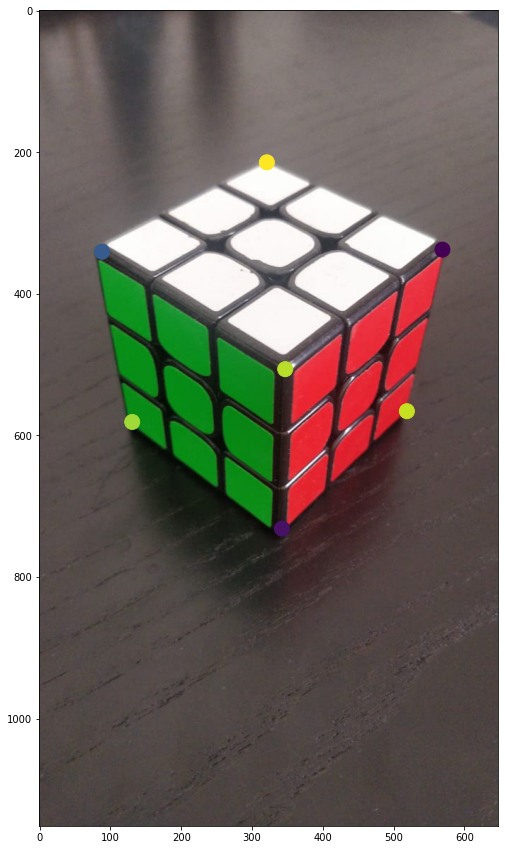

In [3]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('q1/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [4]:
#Image points in image_points
#World points in world_points

world_points = [[0,0,0], [0,12,0], [12,12,0], [12,0,0], [0,0,-12], [0,12,-12], [12,12,-12]]
world_points = np.asarray(world_points)
ones = np.ones((world_points.shape[0], 1))
world_points = np.concatenate((world_points, ones), axis = 1)
image_points = np.concatenate((image_points, ones), axis = 1)

In [5]:
print(world_points.shape)
print(image_points.shape)

(7, 4)
(7, 3)


Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [6]:
def DLT(image_points, world_points):
    n = world_points.shape[0]
    M = []    
    for i in range(n):
        x = image_points[i][0]
        y = image_points[i][1]
        
        X = world_points[i][0]
        Y = world_points[i][1]
        Z = world_points[i][2]
        
        ax = [X, Y, Z, 1, 0, 0, 0, 0, -x*X, -x*Y, -x*Z, -x]
        ay = [0, 0, 0, 0, X, Y, Z, 1, -y*X, -y*Y, -y*Z, -y]
        M.append(ax)
        M.append(ay)
    
    M = np.asarray(M)
    #Using SVD
    U, S, Vt = np.linalg.svd(M)
    P = Vt[-1,:]/Vt[-1,-1]
    P = P.reshape(3,4)
    return np.asarray(P)
    
P = DLT(image_points, world_points)
    

In [7]:
print(P)

[[ 2.12843419e+01 -5.68006548e+00  1.63754983e+01  3.41130859e+02]
 [-6.78293750e+00 -2.80690275e+01  7.76206102e+00  7.31977209e+02]
 [ 1.24036527e-02 -1.81884246e-02 -8.44094641e-03  1.00000000e+00]]


### Theory

- Explain how DLT is implemented and show why it works (proof)
- When does DLT fail?

`Direct Linear Transform` uses 6 or more known points to determine the `rotation matrix` $R$, `location of projection centre (camera)` $x_{O}$, and `callibration matrix` $K$.

In the given `equation` $x = PX$

$x$ denotes the `2D pixel coordinates`.
$P$ denotes the `projection matrix`, which describes the `2D to 3D mapping`.
$X$ denotes the `3D world coordinates`.

Here $x$ is observed and $X$ is known and we need to solve for $P$.

$P$ can be expressed in the following manner:

$$P = K \begin{bmatrix} R & -Rx_{O} \\ 0^{T} & 1 \end{bmatrix}$$

We can rearrange these equations such that for each point pictured, we get two small equations, and each equation contains a coefficient vector $a$. We can also introduce a new 12 dimensional vector $p$ which contains all the terms of $P$ in a linear vector form instead of a matrix.

The product of $a$ and $p$ should be 0. Since each observation point has 2 coordinates, we can get 2 equations, one for the `x coordinate` and one for the `y coordinate`.

Since each observation point generates 2 equations,  we need 12 equations (for 12 components of p). Therefore, 6 points are enough to get the 12 unknown values in the $p$ vector.

$$a_{x}^{T}p = 0 \: \mathrm{and} \: a_{y}^{T}p = 0$$

Now, we can arrange all of these coefficients as `row vectors` in a measurement matrix $M$ such that 

$$Mp = 0$$



Now we can use `SVD` to solve this homogenous linear system by estimating singular values in singular vectors. We do this by taking the singular vector that corresponds to smallest singular value , which is a vector that brings this equation to 0 or a sufficiently small value (because of noise or other problems). 

Now, the terms of $p$ can be rearranged into the matrix $P$.

We can use QR decomposition on $P$ to get `rotation matrix` R, `location of projection centre (camera)` $x_{0}$, and `callibration matrix` $K$.

Therefore we localize the camera, and estimate the linear callibration parameters using 6 or more points.

### Proof

$$a_{x_{i}}^{T}p = (-X_{i}, -Y_{i}, -Z_{i}, -1, 0, 0, 0, 0, x_{i}X_{i}, x_{i}Y_{i}, x_{i}Z_{i}, x_{i}) \begin{bmatrix} p_{11} \\ p_{12} \\ p_{13} \\ p_{14} \\p_{21} \\ p_{22} \\ p_{23} \\ p_{24}\\p_{31} \\ p_{32} \\ p_{33} \\ p_{34} \end{bmatrix}$$

Here $p_{11}$ to $p_{14}$ are terms from the first column ($A$) of $P$, $p_{21}$ to $p_{24}$ are terms from the second column ($B$) of $P$, and $p_{31}$ to $p_{34}$ are terms from the third column ($C$) of $P$.

Here $(-X_{i}, -Y_{i}, -Z_{i}, -1)$ is $-X_{i}^{T}$, $(0,0,0,0)$ is $0$, and $(x_{i}X_{i}, x_{i}Y_{i}, x_{i}Z_{i}, x_{i})$ is $x_{i}X_{i}^{T}$.

And for x coordinates:

($-X_{i}^{T}$, $0$, $x_{i}X_{i}^{T}$) $\begin{bmatrix} A \\ B \\ C \end{bmatrix}$

 $ = -X_{i}^{T}A + x_{i}X_{i}^{T}C$

And for y coordinates:

($0$, $-X_{i}^{T}$, , $y_{i}X_{i}^{T}$) $\begin{bmatrix} A \\ B \\ C \end{bmatrix}$

 $ = -X_{i}^{T}B + y_{i}X_{i}^{T}C$

____________________________________________________________________________________________________________________

DLT can fail when the points are all lying a plane because the system degenerates and we can not find an appropriate solution. Even when the points are lying near a plane, then it becomes numerically unstable.

## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [8]:
#Get reprojected points
def get_points(P, X):
    x = P@X.T
    x = x / x[2]
    return x.T[:,0:2]

#Get reprojection error
def get_err(x, X, P):
    points = get_points(P, X)
    x = x.T
    x = x / x[2]
    x = x.T[:,0:2]
    error = np.sqrt(np.mean(np.sum((points - x)**2,1)))
    return error

In [9]:
print("Reprojection Error is:", get_err(image_points, world_points, P))

Reprojection Error is: 1.5208988733062623


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [10]:
def ret_RKT(P):
    #Finding H, h followed by K, R, C
    H = np.asarray(P[:,0:3])
    H_inv = np.linalg.inv(H)
    h = np.asarray(P[:,3])
    #QR decomposition
    Rt, K_inv = np.linalg.qr(H_inv)
    R = Rt.T
    K = np.linalg.inv(K_inv)
    C = -1*(H_inv@h)
    T = -1*(R@C)
    return R, K, T
    

R, K, T = ret_RKT(P)
print("R: ")
print(R)
print("K: ")
print(K)
print("T: ")
print(T)

R: 
[[-0.6242879  -0.06443092 -0.77853277]
 [-0.57750721 -0.63305932  0.51548164]
 [-0.52607038  0.77141724  0.35800195]]
K: 
[[-2.56704473e+01 -2.54773779e-01 -9.71630196e+00]
 [ 0.00000000e+00  2.56877547e+01 -1.53057961e+01]
 [-0.00000000e+00 -0.00000000e+00 -2.35779339e-02]]
T: 
[  2.73235391   3.22408727 -42.41253726]


#### Verifying the R, K, T Values

Use `np.isclose` to verify the matrix

In [11]:
P1 = K@(np.hstack((R, T.reshape(3,1))))
print(np.isclose(P, P1))

[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


**Reproject the world points with P matrix you have obtained via DLT and visualize**

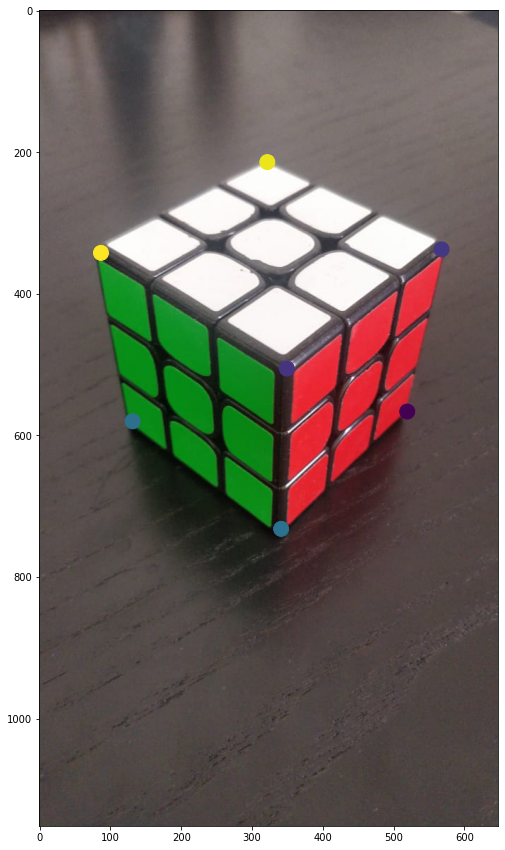

In [12]:
points = get_points(P, world_points)

%matplotlib inline
N = len(points)
points = np.array(points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('q1/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(points[:,0], points[:,1], c=colors, s=area)
plt.show()

### Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in `q1/zhangs` folder for this task. Familiarize yourself with the different parameters for this method.

**Reference**: https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html

In [1]:
import cv2

In [14]:
chessboard  = []
for y in range(6):
    for x in range(8):
        chessboard.append([x, y, 0])
chessboard = np.asarray(chessboard).astype(np.float32)

In [15]:
TwoD = []
ThreeD = []
for i in range(5456, 5471):
    image = mpimg.imread('./q1/Zhangs/IMG_' + str(i) + '.JPG')
    image = cv2.resize(image, (int(image.shape[1] * 0.5), int(image.shape[0] * 0.5)), interpolation = cv2.INTER_AREA)
    ret, corners = cv2.findChessboardCorners(image, (8,6))
    if ret:
        ThreeD.append(chessboard)
        TwoD.append(corners)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(ThreeD, TwoD, (image.shape[1],image.shape[0]), None, None)
print("Camera Calibration Matrix:")
print(mtx)

Camera Calibration Matrix:
[[6.83172095e+03 0.00000000e+00 1.65491718e+03]
 [0.00000000e+00 6.84257034e+03 7.48262274e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


### Verification of Zhang method

0


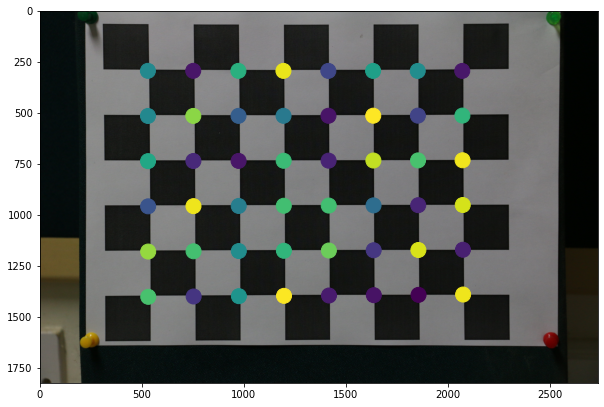

1


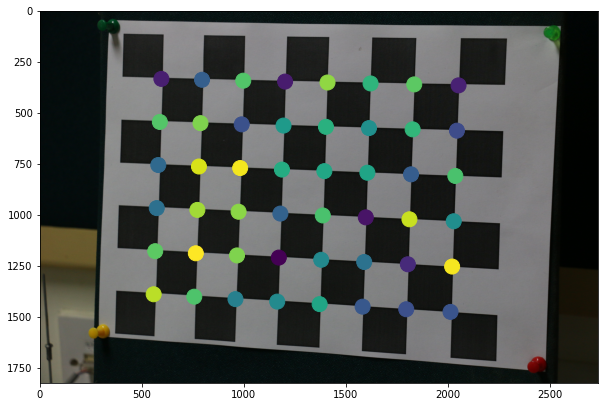

2


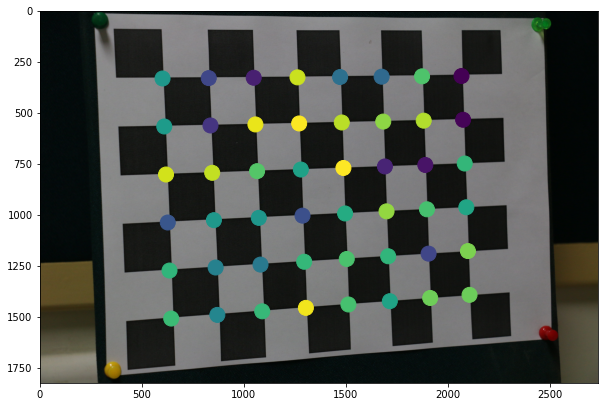

3


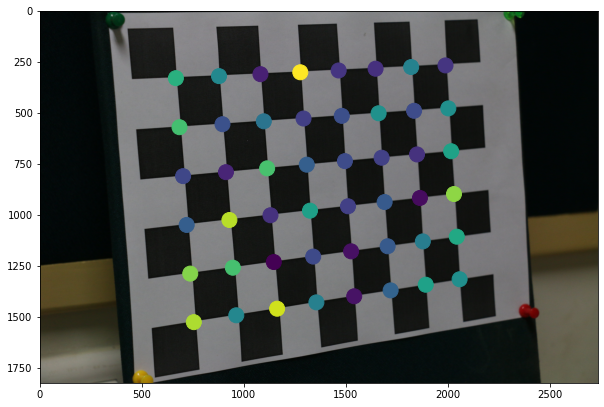

4


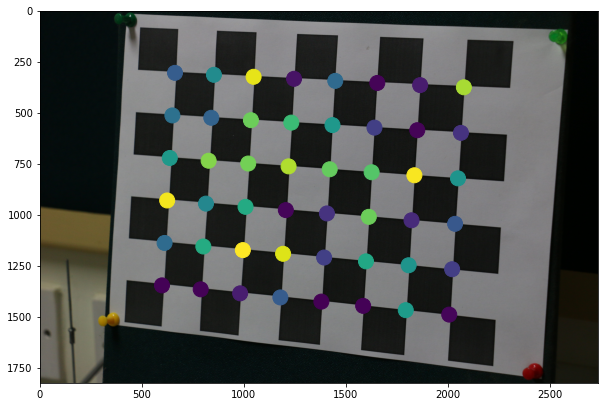

5


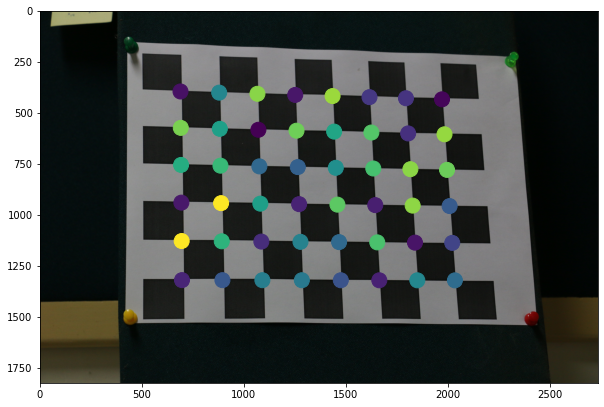

6


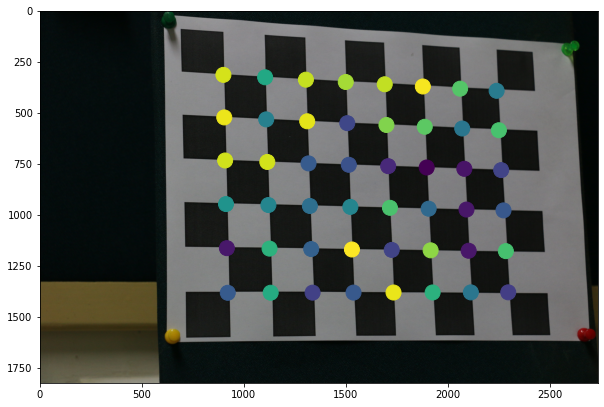

7


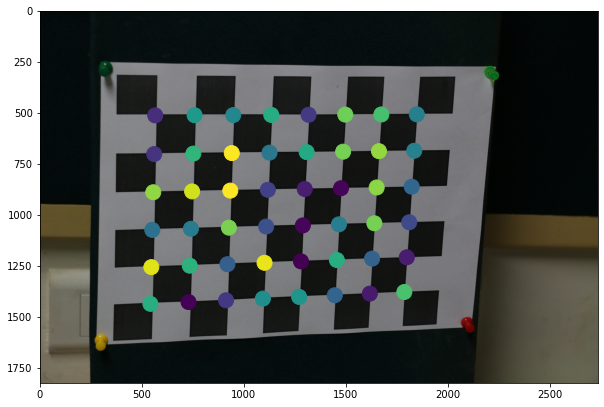

8


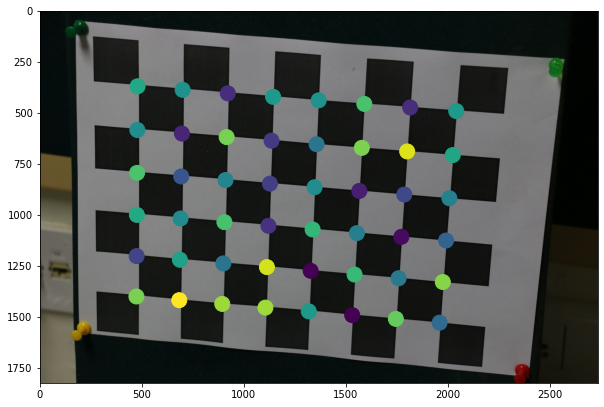

9


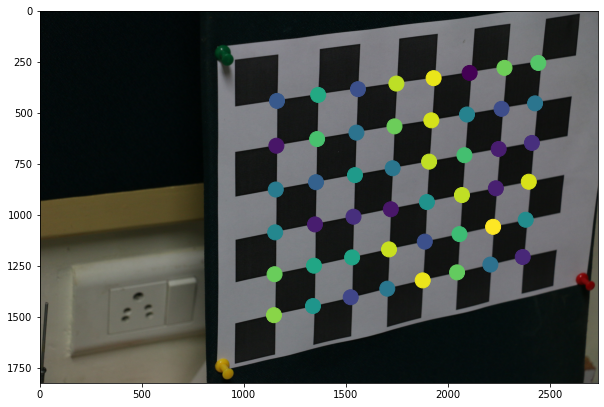

10


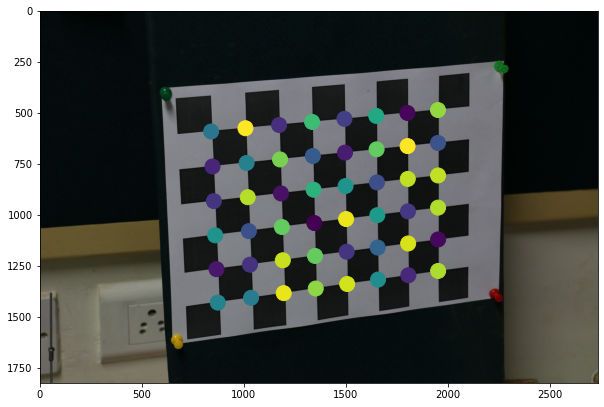

11


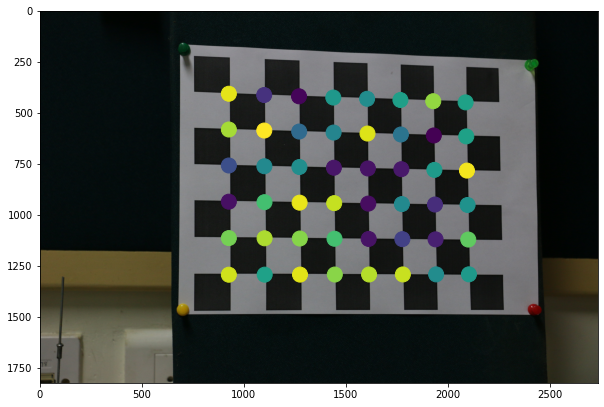

12


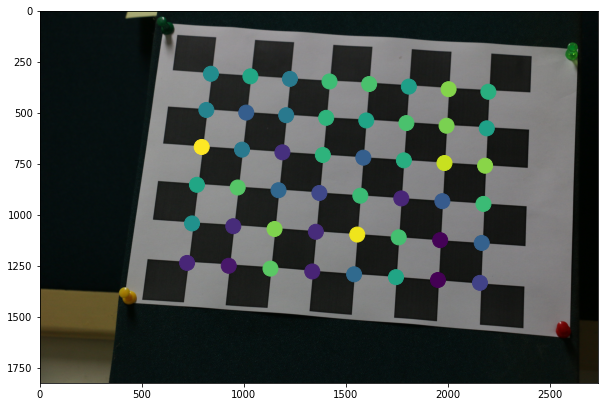

13


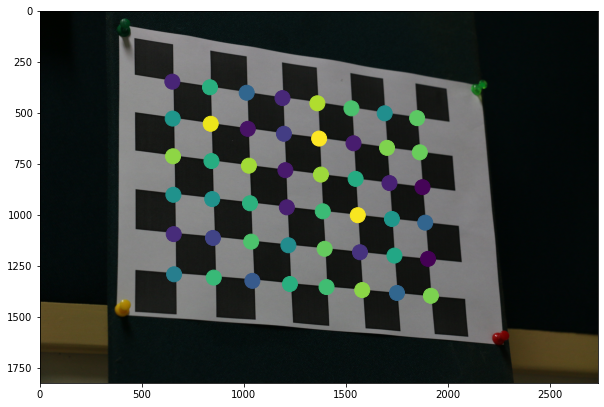

14


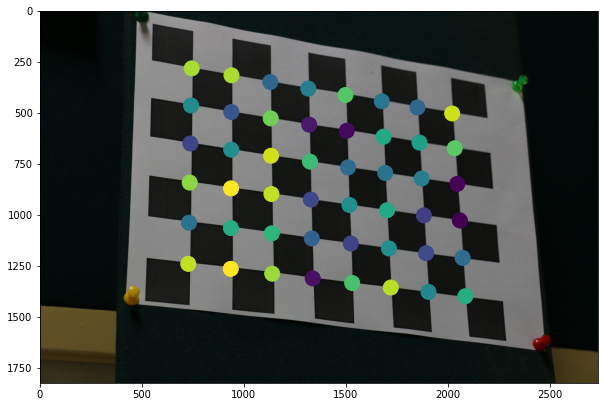

In [16]:
chessboard_points = np.hstack((chessboard, np.ones((48,1)))).astype(np.float32)
for i in range(15):
    print(i)
    rotation_mat = np.zeros(shape=(3, 3))
    Ri = cv2.Rodrigues(rvecs[i], rotation_mat)[0]
    Ti = tvecs[i]
    Ki = mtx
    Pi = Ki@(np.hstack((Ri, Ti.reshape(3,1))))
    points = get_points(Pi, chessboard_points)
    %matplotlib inline
    N = len(points)
    points = np.array(points)
    fig = plt.figure(figsize=(10,15))

    image=mpimg.imread('./q1/Zhangs/IMG_' + str(5456+i) + '.JPG')
    image=cv2.resize(image, (int(image.shape[1] * 0.5), int(image.shape[0] * 0.5)), interpolation = cv2.INTER_AREA)
    imgplot = plt.imshow(image)

    colors = np.random.rand(N)
    area = (15 * np.ones(N))**2 

    plt.scatter(points[:,0], points[:,1], c=colors, s=area)
    plt.show()

---
### 4.2 Epipolar lines
#### Task 1

For this task, you have been given two images of the same scene taken from different view-points. You should first estimate the fundamental matrix from these two images.

<img src="./q2/img1.jpg" alt="image 1" width="400"/>
<img src="./q2/img2.jpg" alt="image 2" width="400"/>


Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image. For this question you will need to compute the F matrix on your own without using inbuilt functions. 

### Fundamental matrix and epipolar lines

The eight point algorithm is used to estimate the fundamental matrix. Here, 10 points in the images are taken. These points are then normalized before applying the algorithm. The rank-2 constraint if enforced on the fundamental matrix and it is then denormalized.

$P \rightarrow p  = \begin{bmatrix}u \\ v \\ 1 \end{bmatrix}$

$P \rightarrow p'  = \begin{bmatrix}u' \\ v' \\ 1 \end{bmatrix}$

$$p^{T}Fp' = 0$$

$$\Rightarrow (u, v, 1) \begin{pmatrix} F_{11} & F_{12} & F_{13} \\F_{21} & F_{22} & F_{23} \\ F_{31} & F_{32} & F_{33} \end{pmatrix} \begin{pmatrix} u' \\ v' \\ 1 \end{pmatrix} = 0$$
$$\Rightarrow (uu', uv', u, vu', vv', v, u', v', 1) \begin{pmatrix}F_{11} \\ F_{12} \\ F_{13} \\ F_{21} \\ F_{22} \\ F_{23} \\ F_{31} \\ F_{32} \\ F_{33} \end{pmatrix} = 0$$

$$w \begin{pmatrix} u_{1}u_{1}' & u_{1}v_{1}' & u_{1} & v_{1}u_{1}' & v_{1}v_{1}' & v_{1} & u_{1}' & v_{1}' & 1 \\ u_{2}u_{2}' & u_{2}v_{2}' & u_{2} & v_{2}u_{2}' & v_{2}v_{2}' & v_{2} & u_{2}' & v_{2}' & 1 \\ u_{3}u_{3}' & u_{3}v_{3}' & u_{3} & v_{3}u_{3}' & v_{3}v_{3}' & v_{3} & u_{3}' & v_{3}' & 1 \\ u_{4}u_{4}' & u_{4}v_{4}' & u_{4} & v_{4}u_{4}' & v_{4}v_{4}' & v_{4} & u_{4}' & v_{4}' & 1 \\ u_{5}u_{5}' & u_{5}v_{5}' & u_{5} & v_{5}u_{5}' & v_{5}v_{5}' & v_{5} & u_{5}' & v_{5}' & 1 \\ u_{6}u_{6}' & u_{6}v_{6}' & u_{6} & v_{6}u_{6}' & v_{6}v_{6}' & v_{6} & u_{6}' & v_{6}' & 1 \\ u_{7}u_{7}' & u_{7}v_{7}' & u_{7} & v_{7}u_{7}' & v_{7}v_{7}' & v_{7} & u_{7}' & v_{7}' & 1 \\ u_{8}u_{8}' & u_{8}v_{8}' & u_{8} & v_{8}u_{8}' & v_{8}v_{8}' & v_{8} & u_{8}' & v_{8}' & 1 \end{pmatrix} \begin{pmatrix} F_{11} \\ F_{12} \\ F_{13} \\ F_{21} \\ F_{22} \\ F_{23} \\ F_{31} \\ F_{32} \\ F_{33} \end{pmatrix} = 0 $$

In a homogenous system $Wf = 0$

Rank 8 $\rightarrow$ a unique non-zero solution exists.

If $N > 8$ $\rightarrow$ least squares solution by singular value decomposition $\rightarrow$ $\hat{F} \| f\| = 1 $


$$p^{T} \hat{F} p' = 0$$

The estimated $$\hat{F}$$ may have full rank (det{$F$} $\neq$ $\hat{0}$)

Find F that minimizes $\| F - \hat{F}\| = 0$ (Frobenius norm)


Subject to det($F$) $ = 0$

SVD can be used to solve this problem


For any point x in the first image, the corresponding epipolar line is $l′ = Fx$. Similarly, $l = F^{T}x′$ represents the epipolar line corresponding to x′ in the second image. The circle function from cv2 is used to plot the coordinates of the points on the images. The epipolar line is obtained by multiplying the F matrix to the points. The line function is used to plot the epipolar lines in the form $ax+by+c$ on the images which is found by passing two coordinates. These two coordinates are found by first putting the value of x as 0, which gives y as $-c/b$ and putting x as MAX (maximum possible value of x) which gives y as $-(c + a*x)/b$.



In [17]:
def compute_fundamental(x1,x2):
    n = x1.shape[1]

    # build matrix for equations
    A = []

    for i in range(n):
        x = x1[0,i]
        xx = x2[0,i]
        y = x1[1,i]
        yy = x2[1,i]
        A.append(np.asarray([x*xx, x*yy, x, y*xx, y*yy, y, xx, yy, 1]))

    A = np.asarray(A)

    U,S,V = np.linalg.svd(A)
    F = V[-1].reshape(3,3)
    U,S,V = np.linalg.svd(F)
    S[2] = 0
    F = U@((np.diag(S))@V)
    return F/F[2,2]

def fundamental_matrix(x1,x2):
    n = x1.shape[1]

    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2],axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])
    x1 = np.dot(T1,x1)
    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2],axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
    x2 = np.dot(T2,x2)

    F = compute_fundamental(x1,x2)

    F = np.dot(T1.T,np.dot(F,T2))

    return F/F[2,2]

In [27]:
def epipolar_lines(name_1, name_2, points1, points2, F):
    img1 = plt.imread(name_1)
    img2 = plt.imread(name_2)
    MAX = img1.shape[1]

    for i in range(points1.shape[0]):
        # making homogenous coordinates
        point_arr = np.array([points1[i][0], points1[i][1], 1])        
        line = F @ point_arr
        # ax + by + c = 0
        a = line[0]; b = line[1]; c = line[2]
        x1, y1 = [0, int(-c / b) ] 
        x2, y2 = [MAX, int(-(c + a * MAX) / b) ]
        color = [np.random.randint(1, 255), np.random.randint(1, 255), np.random.randint(1, 255)]
        img1 = cv2.line(img1, (x1, y1), (x2, y2), color, 4) 
        img1 = cv2.circle(img1, (int(points2[i][0]), int(points2[i][1])), 10, color, -1)
        img2 = cv2.circle(img2, (int(points1[i][0]), int(points1[i][1])), 10, color, -1)
        
    return img1, img2

In [28]:
img1=cv2.cvtColor(cv2.imread('q2/img1.jpg'),cv2.COLOR_BGR2RGB)
img2=cv2.cvtColor(cv2.imread('q2/img2.jpg'),cv2.COLOR_BGR2RGB)

image1_points = np.asarray([[379, 400, 1],
 [449, 487, 1],
 [661, 548, 1],
 [511, 254, 1],
 [506, 391, 1],
 [474, 440, 1],
 [451, 537, 1],
 [498, 354, 1],
 [716, 319, 1],
 [645, 357, 1]])

image2_points = np.asarray([[388, 345, 1],
 [439, 412, 1],
 [661, 420, 1],
 [477, 189, 1],
 [473, 301, 1],
 [453, 360, 1],
 [453, 441, 1],
 [475, 287, 1],
 [686, 185, 1],
 [616, 254, 1]])

F = fundamental_matrix(image2_points.T, image1_points.T)
print(F)

[[ 3.92030580e-06 -8.11846096e-06 -5.71869442e-05]
 [ 8.81298346e-06  1.43241875e-06 -4.75225759e-03]
 [-3.57571183e-03  3.36991415e-03  1.00000000e+00]]


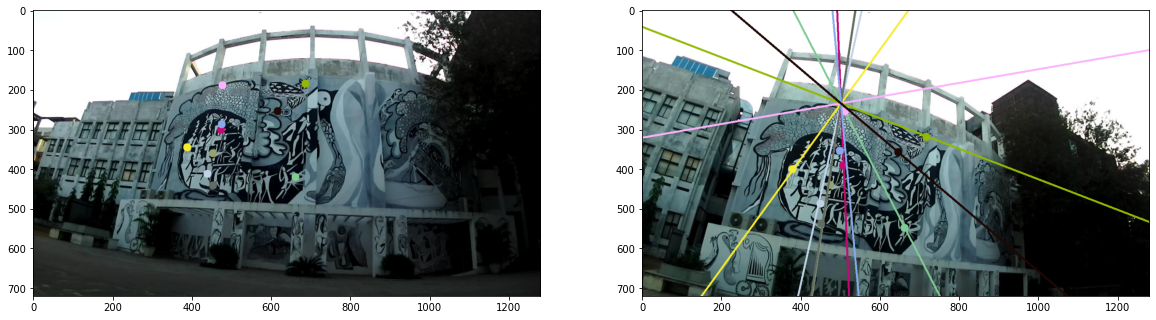

In [29]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (20, 10)) 
ax = np.reshape(ax, (-1,))
img1, img2 = epipolar_lines('q2/img1.jpg','q2/img2.jpg', image2_points, image1_points, F.T)
ax[0].imshow(img2)
ax[1].imshow(img1)

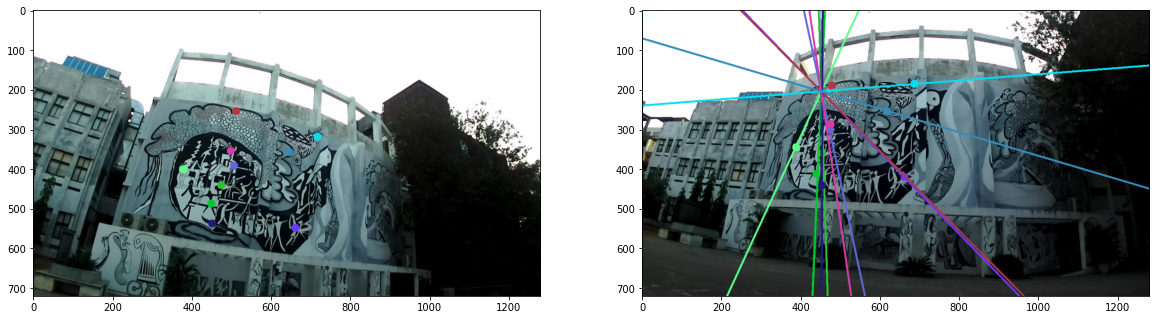

In [30]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (20, 10))  
ax = np.reshape(ax, (-1,))
img1, img2 = epipolar_lines('q2/img2.jpg','q2/img1.jpg', image1_points, image2_points, F)
ax[0].imshow(img2)
ax[1].imshow(img1)

**Provide a clear explanation on your approach for both this task and the next**

#### Task 2
Report the location of the epipoles. Mathematically find the epipoles and verify that the lines intersect at the epipole.

### Epipoles

For any point $x$ (other than $e$) the epipolar line $l′ = Fx$ contains the epipole $e′$. Thus $e′$ satisfies $e′^{T}(Fx) = (e′^{T}F)x = 0$ for all $x$. It follows that $e′^{T}F = 0$, i.e. $e′$ is the left null-space of F. Similarly $Fe = 0$, i.e. $e$ is the right null-space of $F$.

In [31]:
def epipole(F, atol=1e-13, rtol=0):
    F = np.atleast_2d(F)
    u, s, vh = np.linalg.svd(F)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ep_arr = vh[nnz:].conj().T
    ep = []
    for i in range(len(ep_arr)):
        ep.append(ep_arr[i][0])
    return ep

In [32]:
epipole1 = epipole(F.T)
epipole2 = epipole(F)

# Euclidean
print("Epipole of first image:", str(epipole1[0]/epipole1[2]), ",", str(epipole1[1]/epipole1[2]))
print("Epipole of second image:", str(epipole2[0]/epipole2[2]), ",", str(epipole2[1]/epipole2[2]))

Epipole of first image: 451.26216002133026 , 204.99597858677652
Epipole of second image: 501.05286427620456 , 234.90825568954472


____
### 4.3 Drawing a bounding box around a car and localizing it in the camera frame
You’ve been provided with an image, also taken from a self-driving car, that shows another car in front. The camera has been placed on top of the car, 1.65 m from the ground, and assume the image plane is perfectly perpendicular to the ground. K is provided to you. Your task is to draw a 3D-bounding box around the car in front as shown. Your approach should be to place eight points in the 3D world such that they surround all the corners of the car, then project them onto the image, and connect the projected image points using lines. You might have to apply a small 5° rotation about the vertical axis to align the box perfectly. Rough dimensions of the car - h: 1.38 m, w: 1.51, l: 4.10. (Hint: Fix a point on the ground as your world origin.). Also estimate the approximate translation vector to the mid-point of the two rear wheels of the car in the camera frame.

![Kitti car](./q3/image.png)

In [3]:
#World points assuming bottom left back corner of car as origin
world_points = np.asarray([[0,0,0], [1.51,0,0], [0,4.10,0], [1.51,4.10,0], [0,0,1.38], [1.51,0,1.38], [0,4.10,1.38], [1.51,4.10,1.38]])
K = np.asarray([[7.2153e+02,0,6.0955e+02], [0,7.2153e+02,1.7285e+02], [0,0,1]])
world = np.asarray([[0,0,0], [1.51,0,0], [0,4.10,0]])
print(world_points.shape)

(8, 3)


In [4]:
image_points = []
fig = plt.figure(figsize=(20,30))

img = mpimg.imread('q3/image.png')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

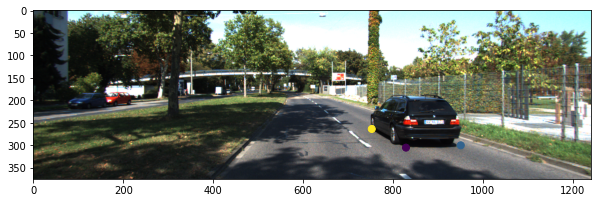

In [5]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
#print(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('q3/image.png')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (7 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

In [6]:
dist = np.asarray([])
ret, rvecs, tvecs = cv2.solveP3P(world, image_points, K, dist, flags= cv2.SOLVEPNP_P3P)
R, D = cv2.Rodrigues(rvecs[1])
T = tvecs[1]
RT = np.hstack((R,T))
P = K@RT
ones = np.ones((world_points.shape[0], 1))
world_points_new = np.concatenate((world_points, ones), axis = 1)
x = P@world_points_new.T
x = x/x[2]
x = x.T

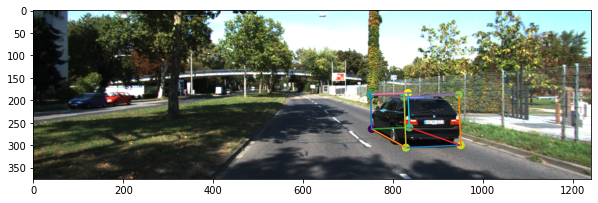

In [7]:
%matplotlib inline
N = len(x)
x = np.array(x)
#print(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('q3/image.png')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (7 * np.ones(N))**2 

plt.scatter(x[:,0], x[:,1], c=colors, s=area)
x1 = [x[0,0], x[1,0]]
y1 = [x[0,1], x[1,1]]
x2 = [x[0,0], x[2,0]]
y2 = [x[0,1], x[2,1]]
x3 = [x[2,0], x[3,0]]
y3 = [x[2,1], x[3,1]]
x4 = [x[3,0], x[1,0]]
y4 = [x[3,1], x[1,1]]
x5 = [x[4,0], x[5,0]]
y5 = [x[4,1], x[5,1]]
x6 = [x[4,0], x[6,0]]
y6 = [x[4,1], x[6,1]]
x7 = [x[6,0], x[7,0]]
y7 = [x[6,1], x[7,1]]
x8 = [x[7,0], x[5,0]]
y8 = [x[7,1], x[5,1]]
x9 = [x[4,0], x[0,0]]
y9 = [x[4,1], x[0,1]]
x10 = [x[3,0], x[7,0]]
y10 = [x[3,1], x[7,1]]
x11 = [x[6,0], x[2,0]]
y11 = [x[6,1], x[2,1]]
x12 = [x[1,0], x[5,0]]
y12 = [x[1,1], x[5,1]]
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.plot(x3,y3)
plt.plot(x4,y4)
plt.plot(x5,y5)
plt.plot(x6,y6)
plt.plot(x7,y7)
plt.plot(x8,y8)
plt.plot(x9,y9)
plt.plot(x10,y10)
plt.plot(x11,y11)
plt.plot(x12,y12)
plt.show()